# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Funktionen definieren

In [2]:
def select_every_12th_with_start(arr, start_index):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 11")

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])
    
    return selected_elements

def linear_reg(x, m, t):
    return m*x + t

def generate_counting_array(length):
    return np.arange(length)

    
def selecting_month(arr, start_index, start_date, end_date):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 12")  # Change 11 to 12

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])

    tmp = xr.concat(selected_elements, dim="time")  # Concatenate the selected elements
    tmp = tmp.sel(time=slice(start_date, end_date))
    
    return tmp


def fit_count(arr):
    return generate_counting_array(len(arr))



def selecting_tf(arr,start_time, end_time):
    return arr.sel(time = slice(start_time, end_time))



## Daten importieren

In [3]:
# File paths
TMin_file = 'data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'data\cru_ts4.07.1901.2022.tmp.dat.nc\cru_ts4.07.1901.2022.tmp.dat.nc'

# Load datasets
TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg =  xr.open_dataset(TAvg_file)

## Differenz berechnen

In [4]:
#Projeziert auf eine latitude

TMin_Lat = TMin.mean('lon')
TMax_Lat = TMax.mean('lon')
TAvg_Lat = TAvg.mean('lon')

In [5]:
time_values = TMax['time'].values

In [6]:
TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')



In [7]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [13]:
def temperature_diff_selection(grad_min, grad_max):
    return TMax_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmx - TMin_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmn

def TMin_selection(grad_min, grad_max):
    return TMin_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmn

def TMax_selection(grad_min, grad_max):
    return TMax_Lat.sel(lat = slice(grad_min,grad_max)).mean('lat').tmx

## Plots

### Loops Fit

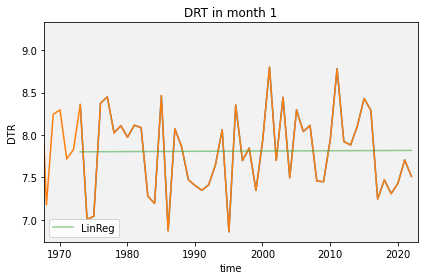

In [9]:
#Parameters
month = 1
lat = 80.25
t_s_d = '1901-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]

# Create an empty DataFrame
columns = ['month', 'slope', 'offset', 'var']
parameters_df = pd.DataFrame(columns=columns)

# Set 'month' as the index
parameters_df.set_index('month', inplace=True)


# Select data
y_data = selecting_month(temperature_difference_Lat.sel(lat = str(lat)),month, t_s_d, t_e)

#Selecting fitting data
y_temp = selecting_tf(y_data, t_s_f, t_e)
x_temp = fit_count(y_temp)

#Fitting
par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

#Producing fitting output
y_fit = linear_reg(x_temp, *par_LinReg)
x_fit = y_temp['time'].values


plt.plot(y_temp['time'].values, y_temp)
plt.plot(y_data['time'].values, y_data)
plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')

#Calculating Varriance

VarDeltaT = np.var(y_temp-y_fit)

#Adding to df
new_entry = {'slope': par_LinReg[0], 'offset': par_LinReg[1], 'var': VarDeltaT}
parameters_df.loc['1'] = new_entry


plt.xlabel('time')
plt.ylabel('DTR')

plt.title('DRT in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)
# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
#plt.savefig(Ordner +'Bilder/LinReg/LinReg_Delta_T_Month'+ str(month)+'.png', dpi = 300)
plt.show()





In [10]:
#Parameters
t_s_d = '1901-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]
month = 1


def LinReg_All_Month(arr, time_start_displayed, time_start_fit, time_end, Name):
    # Create an empty DataFrame
    columns = ['month', 'slope', 'offset', 'var']
    parameters_df = pd.DataFrame(columns=columns)

    # Set 'month' as the index
    parameters_df.set_index('month', inplace=True)

    for month in range(1,13):
        # Select data
        y_data = selecting_month(arr,month, time_start_displayed, time_end)

        #Selecting fitting data
        y_temp = selecting_tf(y_data, time_start_fit, time_end)
        x_temp = fit_count(y_temp)

        #Fitting
        par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

        #Producing fitting output
        y_fit = linear_reg(x_temp, *par_LinReg)
        x_fit = y_temp['time'].values


        # #plt.plot(y_temp['time'].values, y_temp)
        # plt.plot(y_data['time'].values, y_data, marker = 'x', ls = '', label = 'data')
        # plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')

        #Calculating Varriance

        VarDeltaT = np.var(y_temp-y_fit)

        #Adding to df
        new_entry = {'slope': par_LinReg[0]*50, 'offset': par_LinReg[1], 'var': VarDeltaT.values}
        parameters_df.loc[str(month)] = new_entry


        # plt.xlabel('time')
        # plt.ylabel('DTR')

        # plt.title(Name + 'entire pol. reg. in month ' + str(month))

        # plt.xlim(time_values[800], time_values[-1])
        # plt.legend()
        # # Add a subtle background color
        # plt.gca().set_facecolor((0.95, 0.95, 0.95))

        # # Display the plot
        # plt.tight_layout()
        # plt.savefig(Ordner +'Bilder/LinReg/LinReg_'+Name+'_Month_'+ str(month)+'.png', dpi = 300)
        # plt.clf()
    return parameters_df


    

In [47]:
# temperature_diff_selection(60,80)

Ordner = 'Bilder/Selektion7080/'
parameters_TDiff = LinReg_All_Month(temperature_diff_selection(70, 80), t_s_d, t_s_f, t_e, 'DTR')
parameters_TMax = LinReg_All_Month(TMax_selection(70,80), t_s_d, t_s_f, t_e, 'TMax')
parameters_TMin = LinReg_All_Month(TMin_selection(70,80), t_s_d, t_s_f, t_e, 'TMin')

In [48]:
parameters_TDiff['SNR'] =np.abs(parameters_TDiff['slope']/parameters_TDiff['var'])
parameters_TMax['SNR'] = np.abs(parameters_TMax['slope']/parameters_TMax['var'])
parameters_TMin['SNR'] = np.abs(parameters_TMin['slope']/parameters_TMin['var'])

In [49]:
parameters_TMax


slope     offset                  var       SNR
month                                                    
1      2.792341 -28.550924     2.06769933479292  1.350458
2      3.038685 -29.455371   2.6245174347785825  1.157807
3      2.775840 -26.583225   1.1281977400251346   2.46042
4      2.719001 -18.722958     1.18967007657584  2.285509
5      1.674083  -7.962403    0.522192557449743  3.205872
6      1.847939   0.749583   0.3797847891060107  4.865752
7      1.185305   5.184250  0.17499826900453358  6.773239
8      1.480534   2.727513  0.27207664900972295  5.441607
9      1.794876  -4.666811  0.36851457658960657   4.87057
10     3.544610 -15.138253   0.5836951532238246  6.072707
11     3.897580 -23.152881   1.0898821039088689  3.576148
12     2.740805 -26.591507   1.0646467778346567   2.57438

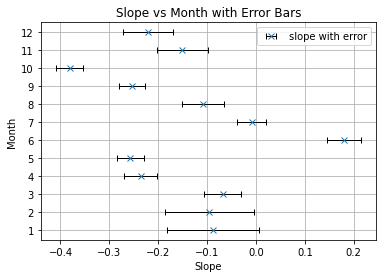

In [50]:
# Create the plot
plt.errorbar(parameters_TDiff['slope'], parameters_TDiff.index, xerr=parameters_TDiff['var'], fmt='x', capsize= 3,ecolor= 'black', elinewidth=1, label='slope with error')
plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

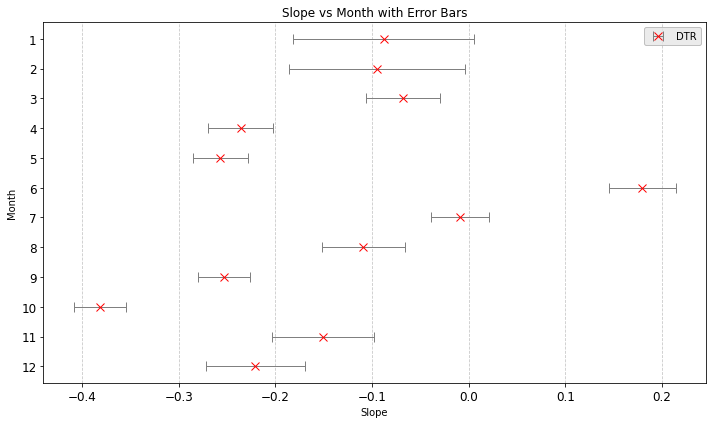

In [51]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TDiff['slope'], parameters_TDiff.index, color = 'r',
    xerr=parameters_TDiff['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='DTR'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.savefig(Ordner + 'DTRperMonth.png', dpi = 300)
plt.show()

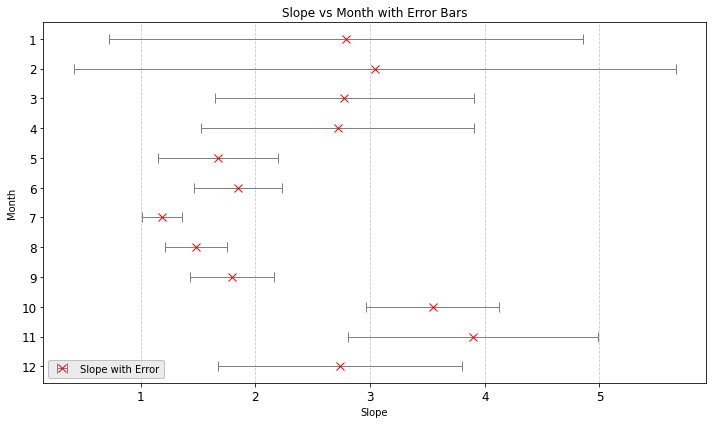

In [52]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'r',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

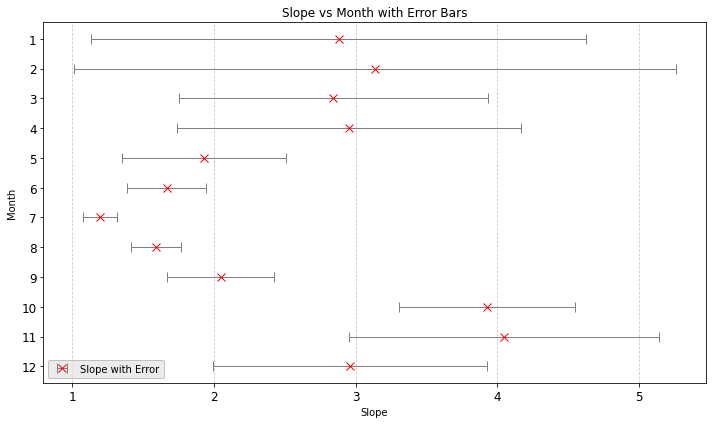

In [53]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='Slope with Error'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.show()

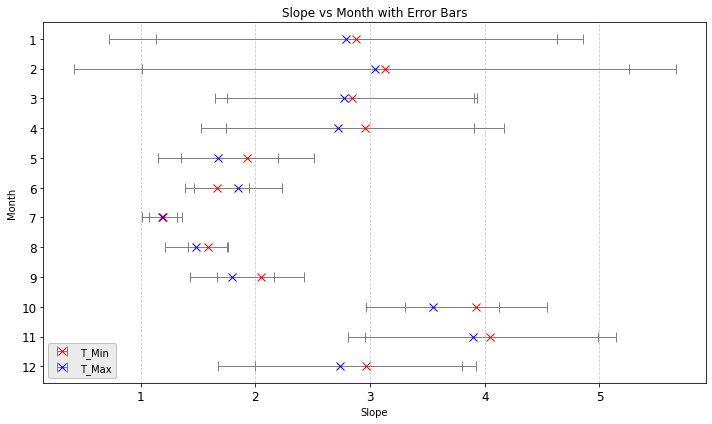

In [54]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['slope'], parameters_TMin.index, color = 'r',
    xerr=parameters_TMin['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='r', markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['slope'], parameters_TMax.index, color = 'b',
    xerr=parameters_TMax['var'], fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8, markeredgecolor='b', markeredgewidth=1, label='T_Max'
)

plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.savefig(Ordner + 'T_Min_T_Max.png', dpi = 300)
plt.show()

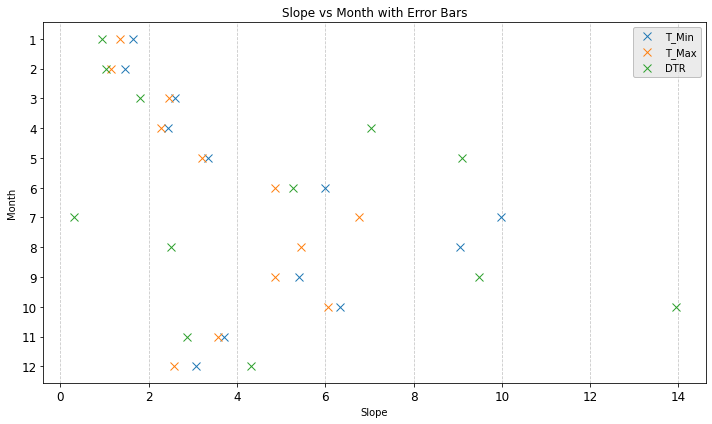

In [55]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size

plt.errorbar(
    parameters_TMin['SNR'], parameters_TMin.index,
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Min'
)

plt.errorbar(
    parameters_TMax['SNR'], parameters_TMax.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='T_Max'
)

plt.errorbar(
    parameters_TDiff['SNR'], parameters_TDiff.index, 
    xerr=None, fmt='x', capsize=5, ecolor='gray', elinewidth=1,
    markersize=8,  markeredgewidth=1, label='DTR'
)


plt.xlabel('Slope')
plt.ylabel('Month')
plt.title('Slope vs Month with Error Bars')

# Customize the tick labels and grid
plt.xticks(fontsize=12)
plt.yticks(parameters_TDiff.index, fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have January at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend with a shadow
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('0.9')
frame.set_edgecolor('0.7')

plt.tight_layout()  # Adjust spacing
plt.savefig(Ordner + 'SNR.png',dpi = 300)
plt.show()

### Hearmap

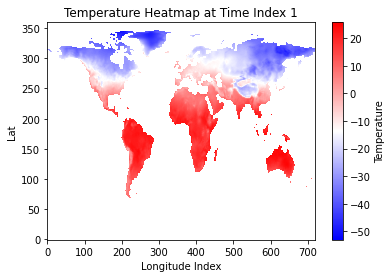

In [56]:
time_index = 1
temperature_data = TMin.isel(time=time_index).tmn#,lon = range(0,260), lat = range(330,360)).tmn

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title(f'Temperature Heatmap at Time Index {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Lat')
plt.show()